In [6]:
%%HTML
<style> code {background-color : pink !important;} </style>

Advanced Lane Finding with Open CV
====

Camera Calibration with OpenCV
==

### The following code generates the image distortion calibration data `This step is mandatory as it generates the calibration data for further operations`

In [13]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(50)

cv2.destroyAllWindows()

### We now have `objpoints` and `imgpoints` needed for camera calibration.  The following cell below calibrates, calculate distortion coefficients, and test undistortion on an sample image!

Text(0.5,1,'Undistorted Image')

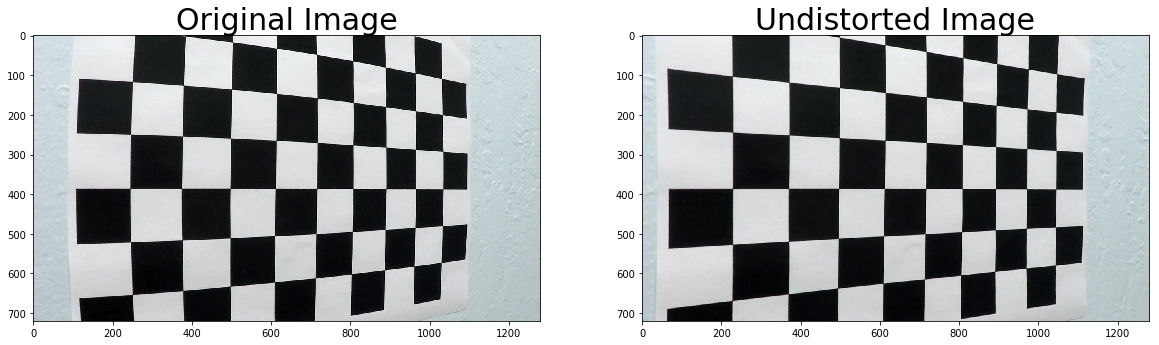

In [15]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

([], <a list of 0 Text yticklabel objects>)

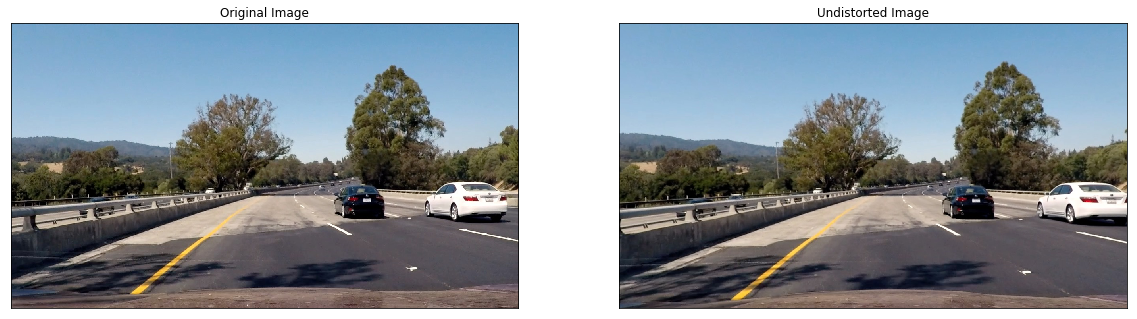

In [17]:
import os
test_image = plt.imread(os.path.join('test_images', 'test4.jpg'))
undistorted_img = cv2.undistort(test_image, mtx, dist)


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.xticks([])
plt.yticks([])

Creating a thresholded binary image
 ==

<Figure size 432x288 with 0 Axes>

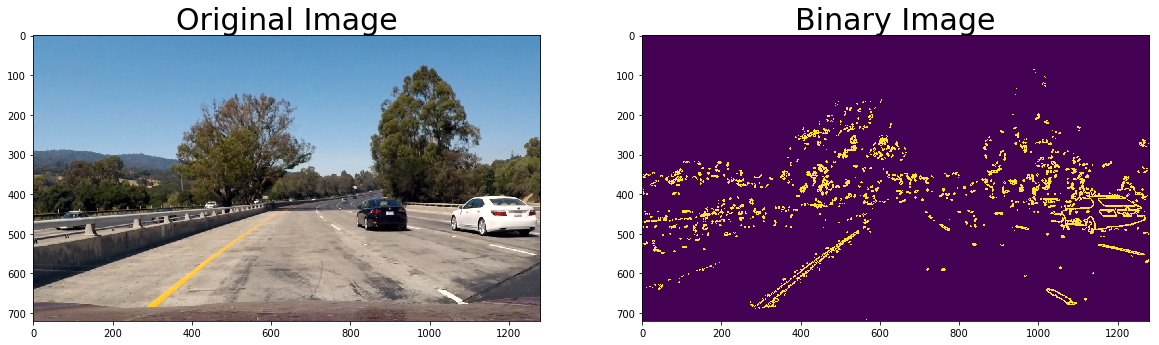

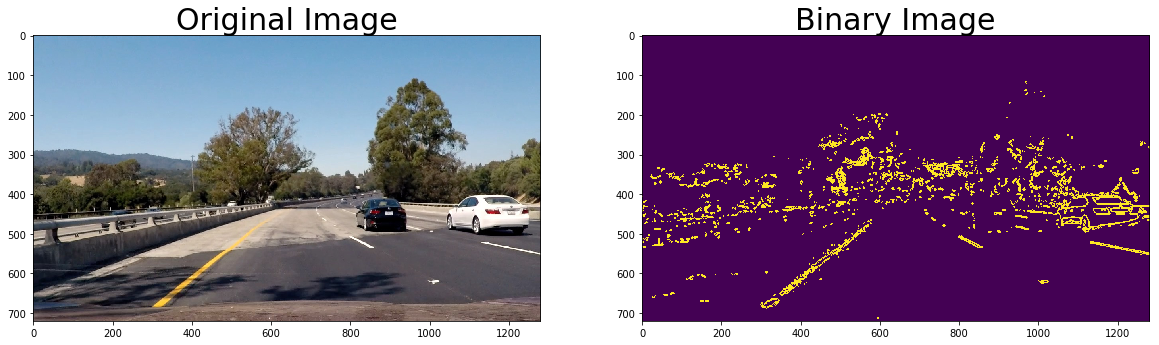

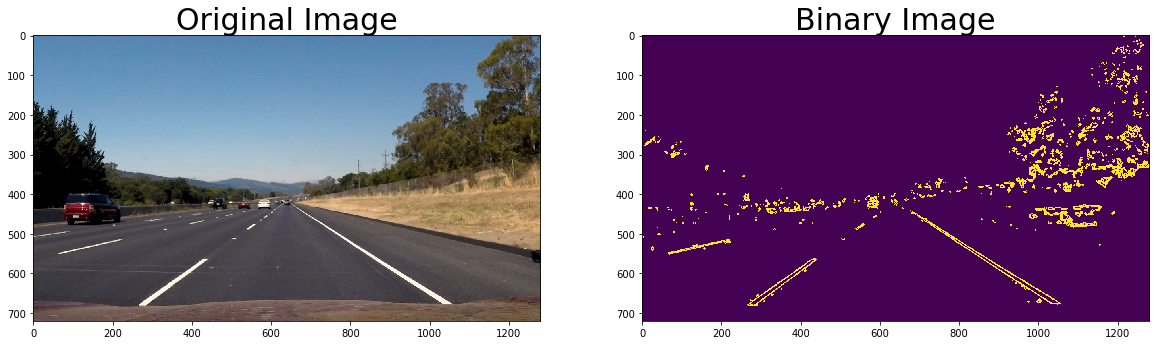

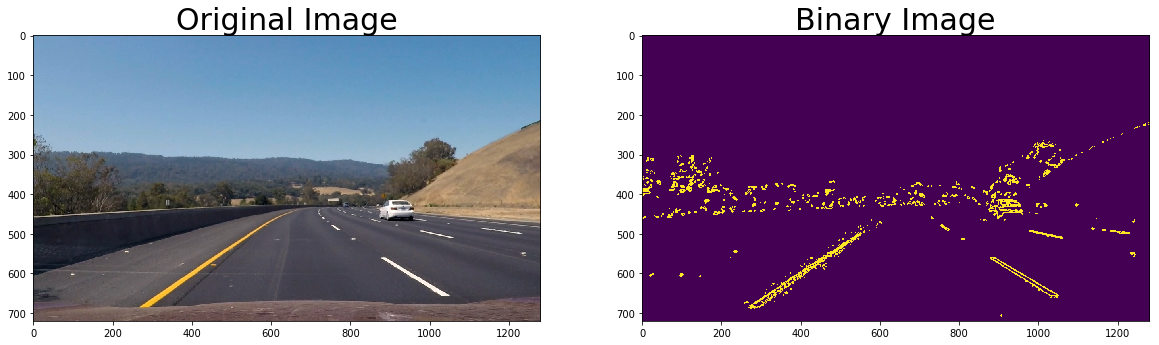

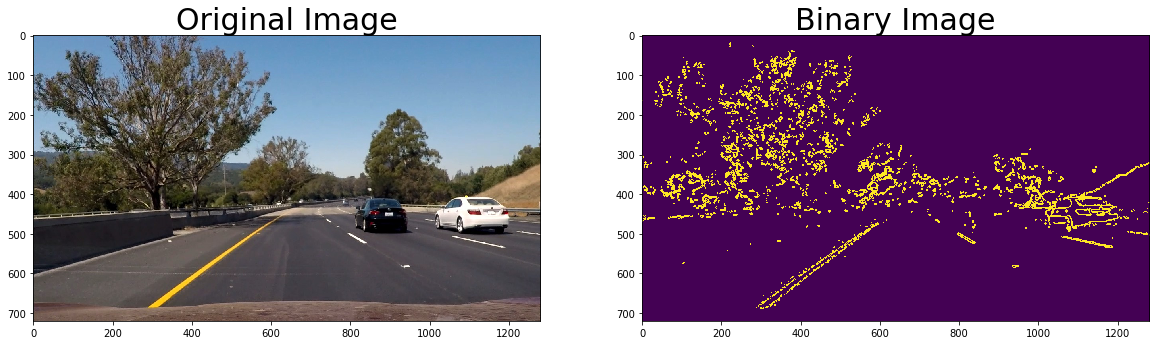

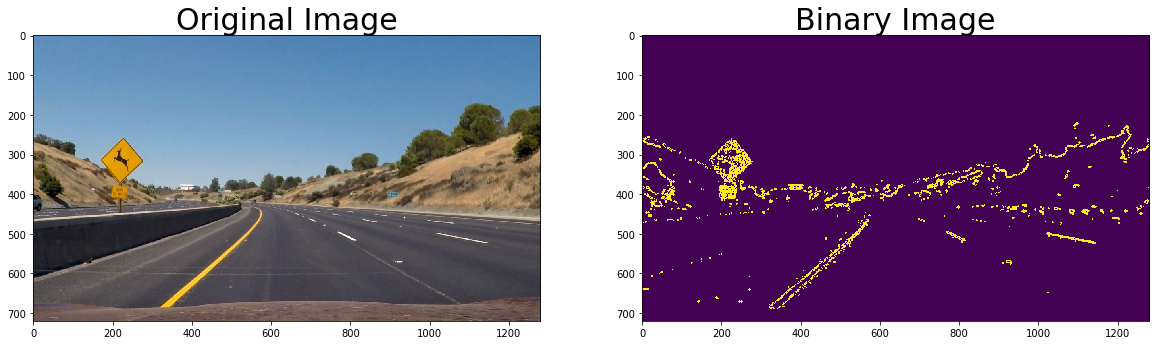

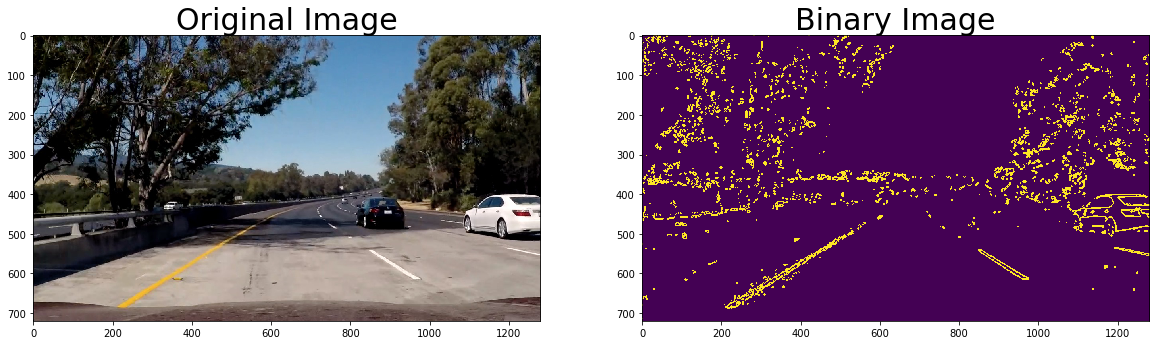

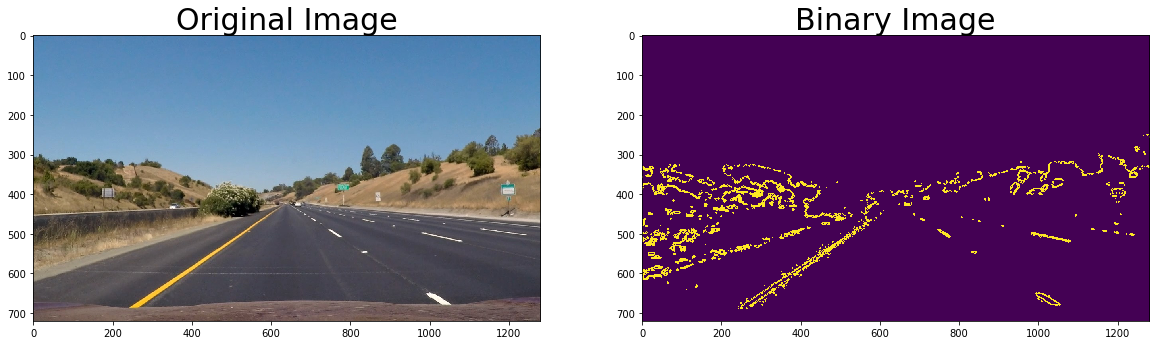

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob

# Read in the image
#image = mpimg.imread('test.jpg')

#image = mpimg.imread('/home/kaleem/workspace/jupyter/udacity/w1/lanefinding/CarND-LaneLines-P1/test_images/solidYellowCurve2.jpg')
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output


def func(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    thresholds_yellow = (hls[:,:,0] < 21) & (hls[:,:,0] > 19 ) | (hls[:,:,1] > 215 )
    color_select = np.copy(image) *0
    color_select[thresholds_yellow] = [255,255,255]
    img_gray = cv2.cvtColor(color_select, cv2.COLOR_BGR2GRAY)
    
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    gradx1 = abs_sobel_thresh(img_gray, orient='x', sobel_kernel=ksize, thresh=(70, 255))
    grady1 = abs_sobel_thresh(img_gray, orient='y', sobel_kernel=ksize, thresh=(50, 255))
    mag_binary1 = mag_thresh(img_gray, sobel_kernel=ksize, mag_thresh=(50, 255))
    combined = np.zeros_like(gradx1)
    combined[((gradx1 == 1) & (grady1 == 1)) | ((mag_binary1 == 1)) ] = 1
    
    return combined

#image = mpimg.imread('/home/kaleem/workspace/jupyter/udacity/w1/lanefinding/CarND-LaneLines-P1/test_images/solidWhiteCurve.jpg')
#func(image)
    
images = glob.glob('test_images/*.jpg')
nCount = 0
for idx, fname in enumerate(images):
    image = mpimg.imread(fname)
    undistorted_img = cv2.undistort(image, mtx, dist)
    img1 = func(image)
    
    plt.figure(nCount)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image)
#    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(img1)
    ax2.set_title('Binary Image', fontsize=30)
    nCount+=1

Perspective Transform
==

Text(0.5,1,'Binary Warped Image')

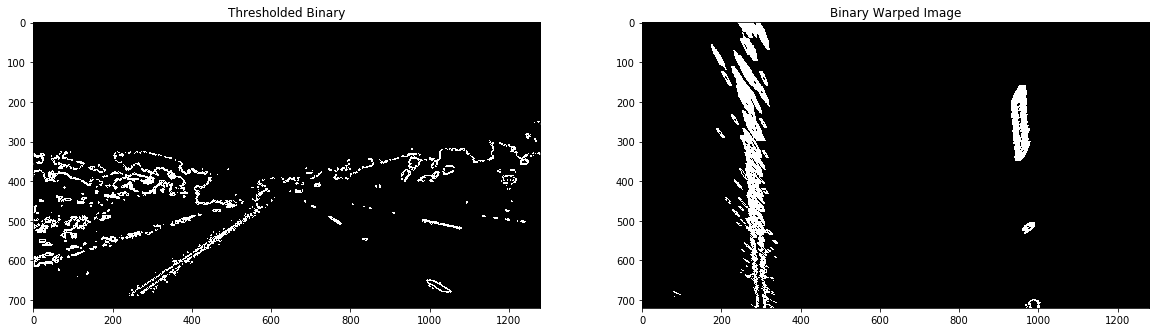

In [21]:
test_image = plt.imread(os.path.join('test_images', 'test3.jpg'))
undistorted_img = cv2.undistort(test_image, mtx, dist)

thresh_binary = func(image)


img_size = (thresh_binary.shape[1], thresh_binary.shape[0])
width, height = img_size
offset = 200
src = np.float32([
    [  548,   476 ],
    [  761,   476 ],
    [ 1136,   673 ],
    [  163 ,   673 ]])
dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
#thresh_binary = func(image)
plt.imshow(thresh_binary, cmap='gray')
plt.title('Thresholded Binary')

plt.subplot(1,2,2)
binary_warped = cv2.warpPerspective(thresh_binary,M, (width, height))
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped Image')

Lane Detection 
==

Text(0.5,1,'Lane Detected')

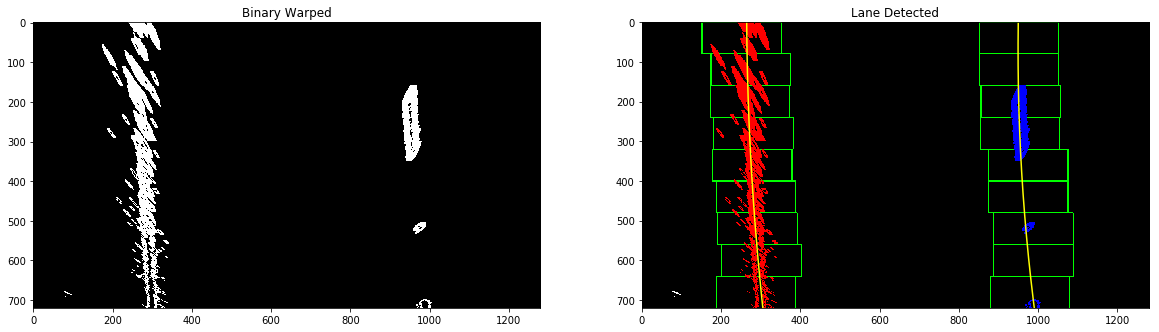

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])


# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 100

# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Steping through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Drawing the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identifing the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Appending these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenating the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extracting left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped')

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Detected')

radius of Curvature
==

In [24]:
ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
y_eval = 700
midx = 650

y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
print("Radius of Curvature: %f" % curvature)

Radius of Curvature: 2194.096015


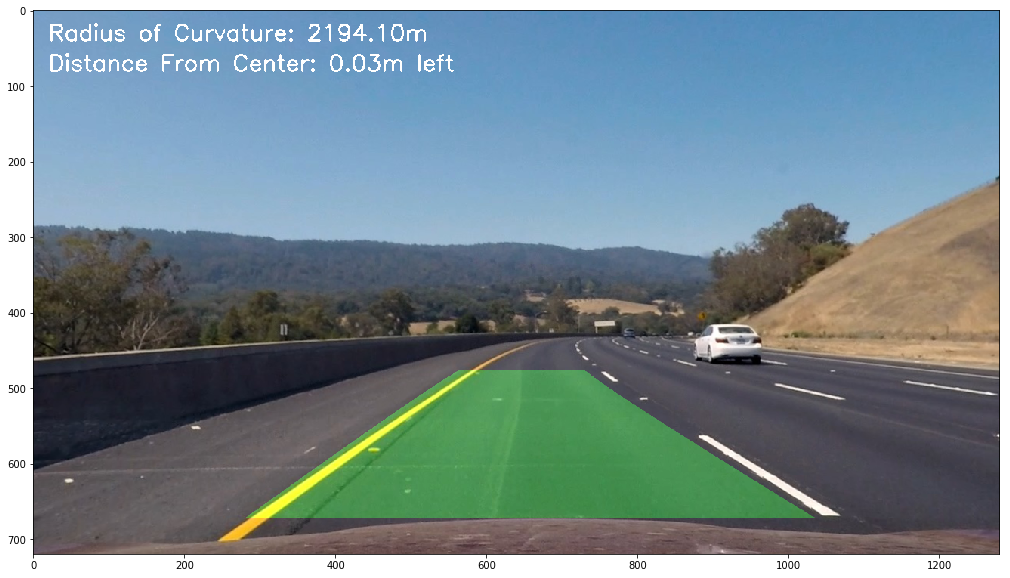

In [25]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

cv2.putText(result,'Radius of Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
if position_from_center < 0:
    text = 'left'
else:
    text = 'right'
cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
plt.figure(figsize=(20,10))
plt.imshow(result)

Applying Lane Identifier in test image
==

/home/kaleem/.local/lib/python2.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in int_scalars


<Figure size 432x288 with 0 Axes>

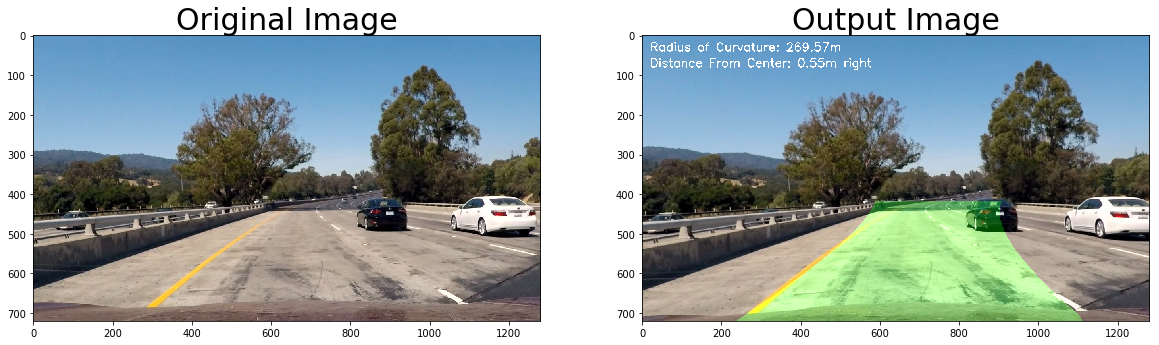

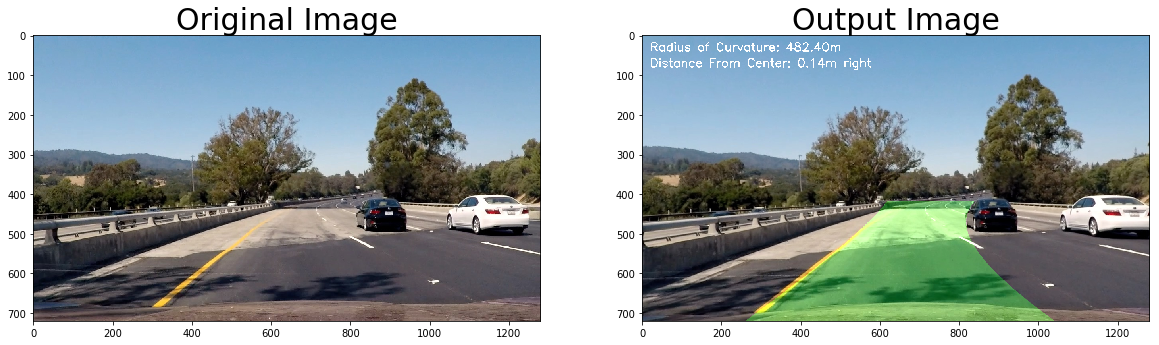

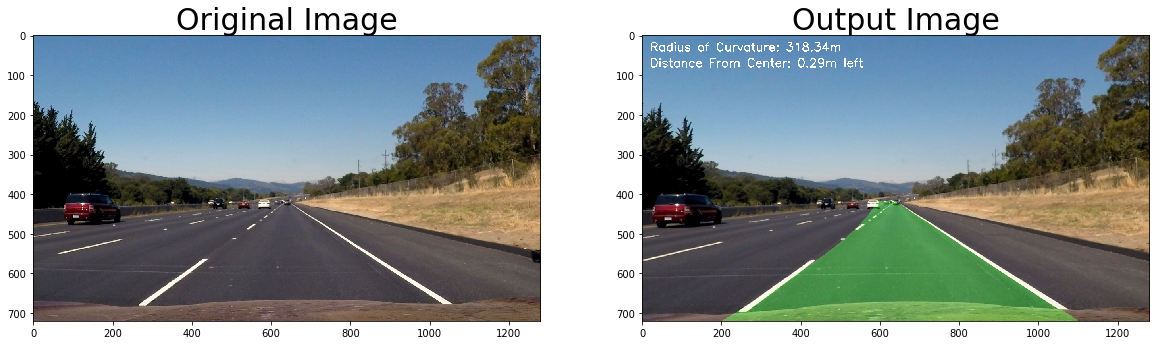

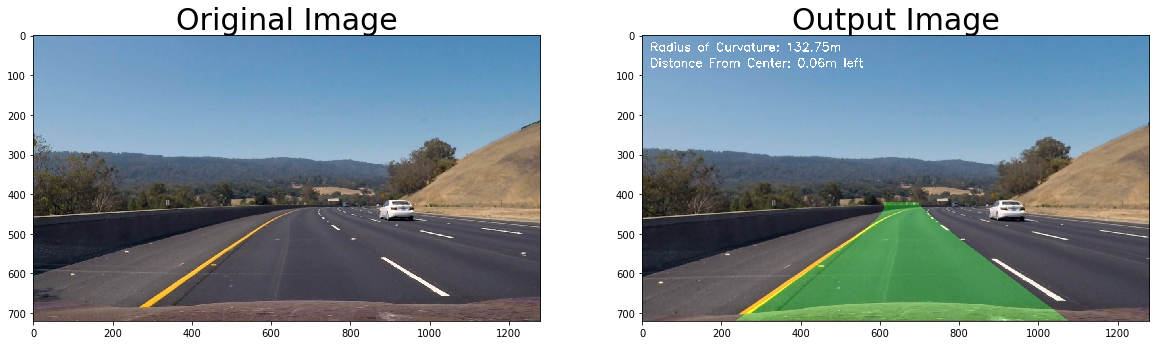

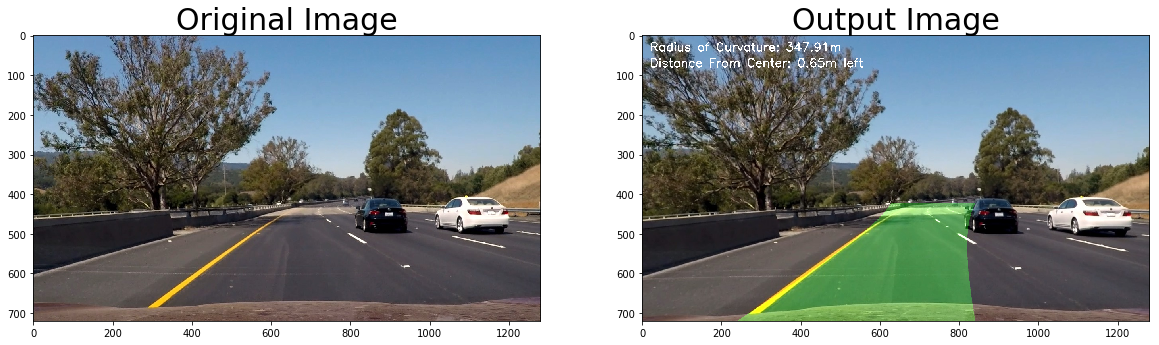

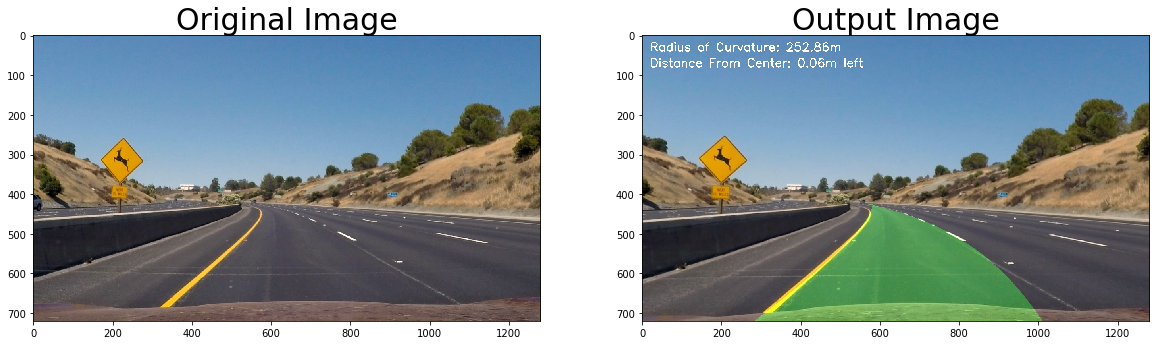

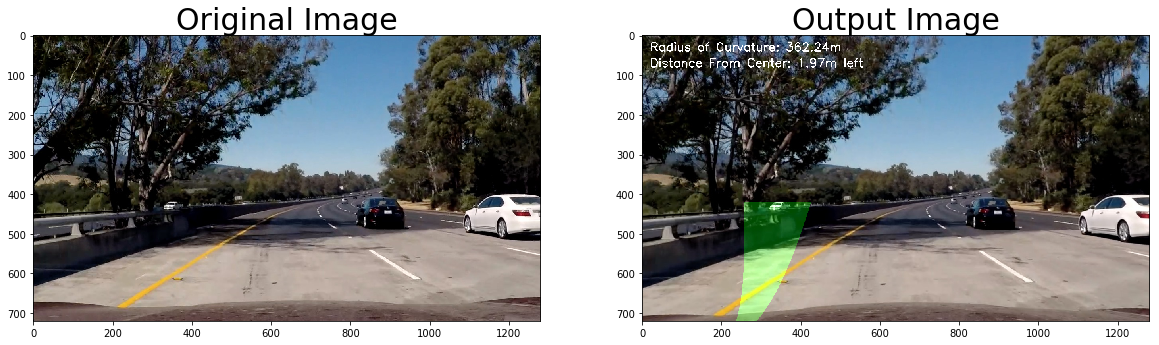

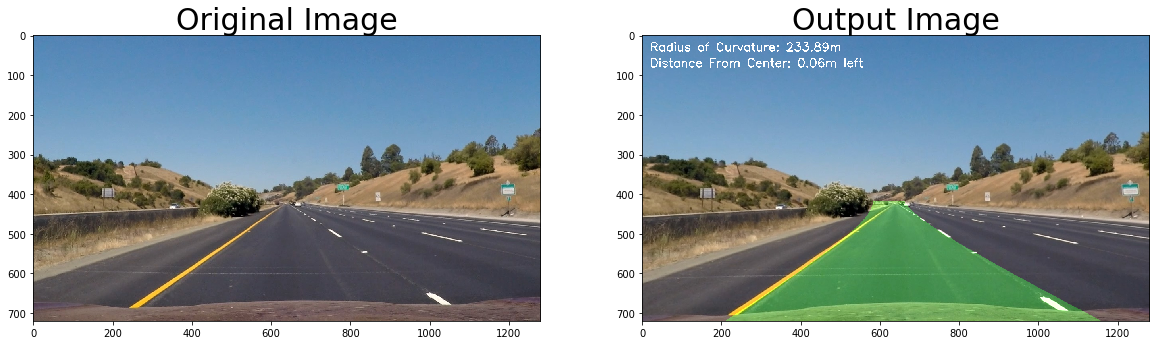

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import math
import sys  
import pickle
#s%matplotlib inline
#sys.reload(sys)  
#sys.setdefaultencoding('utf8')
#GAUSSIAN BLUR PARAMETERS
KERNEL_SIZE = 3

#CANNY EDGE DETECTION PARAMETERS
LOW_THRESHOLD = 75 
HIGH_THRESHOLD = 150 

#REGION OF INTEREST PARAMETERS
H_CONST = 0.08
RIGHT_LANE_SLOPE = 14/32
RIGHT_LANE_CONST = 400
TOP_SHIFT_H = 40 
TOP_SHIFT_V = 40

#HOUGH LINES PARAMETERS
RHO = 3.5 
THETA = np.pi/180
MIN_VOTES = 30    
MIN_LINE_LEN = 5 
MAX_LINE_GAP= 25  
LOWER_EDGE = 800
nYoffset = 0
l1x1 = None
l1y1 = None 
l1x2 = None
l1y2 = None
nC1 = 0

l2x1 = None
l2y1 = None 
l2x2 = None
l2y2 = None
nC2 = 0

al1x1 = None
al1y1 = None 
al1x2 = None
al1y2 = None
al2x1 = None
al2y1 = None 
al2x2 = None
al2y2 = None

Minv = None
mode = 0 # 0 - image, 1 - video



def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    #algorithm logic:
    #aim is to find x_min, y_min, x_max, y_max , slope and intercept for both lanes lines.
    #for each line returned from the hough lines function:
    #   calculate slope
    #   calculate intercept
    #   store positive and negative slope and intercept values separately in arrays.
    #   y_min is the minimum of all the y coordinates.
    #   y_max is the bottom of the image from where the lane lines start.
    #   slope and intercept values for both lines are just the averages of all values stored previously.
    #  x_min and x_max can now be calculated by fitting all the lines in the equation x = (y - intercept)/slope.
    
    #LINE DISPLAY PARAMETERS
    color = [243, 105, 14]
    thickness = 12
    
    #LINE PARAMETERS
    SLOPE_THRESHOLD = 0.3
    Y_MIN_ADJUST = 15
    
    positive_slopes = []
    negative_slopes = []
    
    positive_intercepts = []
    negative_intercepts = []
    
    #named as y_max despte being at the bottom corner of the image due to y axis in reverse direction
    global nYoffset
    y_max = img.shape[0]
    y_min = img.shape[0] + nYoffset
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            #calculate slope for the line
            slope = (y2-y1)/(x2-x1)
            intercept = y2 - (slope*x2)
            
            #for negative slope
            if slope < 0.0 and slope > -float('inf') and abs(slope) > SLOPE_THRESHOLD:
                #print('negative slope')
                negative_slopes.append(slope)
                negative_intercepts.append(intercept)
                
            #for positive slope
            elif slope > 0.0 and slope < float('inf') and abs(slope) > SLOPE_THRESHOLD:
                #print('positive slope')
                positive_slopes.append(slope)
                positive_intercepts.append(intercept)
            
            y_min = min(y_min, y1, y2)
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    y_min+=Y_MIN_ADJUST
    
    #get averages for positive and negative slopes
    positive_slope_mean = np.mean(positive_slopes)
    negative_slope_mean = np.mean(negative_slopes)

    #get averages for potitive and negative intercepts
    positive_intercept_mean = np.mean(positive_intercepts)
    negative_intercept_mean = np.mean(negative_intercepts)
    
    
    #calculation of coordinates for lane for positive slopes
    if len(positive_slopes) > 0:
        x_max = int((y_max  - positive_intercept_mean)/positive_slope_mean)
        x_min = int((y_min - positive_intercept_mean)/positive_slope_mean)
        global l1x1,l1x2,l1y1,l1y2,al1x1,al1x2,al1y1,al1y2,nC1
        l1x1 = x_min
        l1y1 = y_min
        l1x2 = x_max
        l1y2 = y_max
        if mode == 1:
            al1x1 = ((al1x1 * nC1) + l1x1)/(nC1+1)
            al1y1 = ((al1y1 * nC1) + l1y1)/(nC1+1)
            al1x2 = ((al1x2 * nC1) + l1x2)/(nC1+1)
            al1y2 = ((al1y2 * nC1) + l1y2)/(nC1+1)
            nC1 = nC1+1
            cv2.line(img, (int(al1x1), int(al1y1)), (int(al1x2), int(al1y2)), color, thickness)
        else:
            al1x1 = l1x1
            al1y1 = l1y1
            al1x2 = l1x2
            al1y2 = l1y2
            cv2.line(img, (x_min, y_min), (x_max, y_max), color, thickness)
    
    #calculation of coordinates for lane for negative slopes
    if len(negative_slopes) > 0:
        x_max = int((y_max  - negative_intercept_mean)/negative_slope_mean)
        x_min = int((y_min  - negative_intercept_mean)/negative_slope_mean)
#        cv2.line(img, (x_min, y_min), (x_max, y_max), color, thickness)
        
        global l2x1,l2x2,l2y1,l2y2,nC2,al2x1,al2x2,al2y1,al2y2
        l2x1 = x_min
        l2y1 = y_min
        l2x2 = x_max
        l2y2 = y_max
        if mode == 1:
            al2x1 = ((al1x1 * nC2) + l2x1)/(nC2+1)
            al2y1 = ((al1y1 * nC2) + l2y1)/(nC2+1)
            al2x2 = ((al1x2 * nC2) + l2x2)/(nC2+1)
            al2y2 = ((al1y2 * nC2) + l2y2)/(nC2+1)
            nC2 = nC2+1
            cv2.line(img, (al2x1, al2y1), (al2x2, al2y2), color, thickness)
        else:
            al2x1 = l2x1
            al2y1 = l2y1
            al2x2 = l2x2
            al2y2 = l2y2
            cv2.line(img, (x_min, y_min), (x_max, y_max), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, alpha=0.8, beta=1., lambda1=0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, lambda1)

def region_of_interest(img, vertices):
    img = cv2.polylines(img, vertices, True, (0,255,255),3)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        
        #print('here')
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        #print('there')
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output



def func_roi(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    thresholds_yellow = (hls[:,:,0] < 21) & (hls[:,:,0] > 19 ) | (hls[:,:,1] > 215 )
    color_select = np.copy(image) *0
    color_select[thresholds_yellow] = [255,255,255]
    img_gray = cv2.cvtColor(color_select, cv2.COLOR_BGR2GRAY)
    
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    gradx1 = abs_sobel_thresh(img_gray, orient='x', sobel_kernel=ksize, thresh=(70, 255))
    grady1 = abs_sobel_thresh(img_gray, orient='y', sobel_kernel=ksize, thresh=(50, 255))
    mag_binary1 = mag_thresh(img_gray, sobel_kernel=ksize, mag_thresh=(50, 255))
    combined = np.zeros_like(gradx1)
    combined[((gradx1 == 1) & (grady1 == 1)) | ((mag_binary1 == 1)) ] = 1    
    return combined

def get_region_of_interest_vertices(img):
    
    #get image parameters for extracting the region of interest
    img_height = img.shape[0]
    img_width = img.shape[1]

    bottom_left = (img_width/9 - H_CONST*img_width, img_height)
    top_left = (img_width / 2 - (TOP_SHIFT_H ), img_height / 2 + TOP_SHIFT_V)
    top_right = (img_width /2 + TOP_SHIFT_H, img_height/2 + TOP_SHIFT_V)
    bottom_right = (img_width - (RIGHT_LANE_SLOPE*img_width-RIGHT_LANE_CONST) + 
                         (H_CONST*img_width), img_height)
    
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
                        
    #print ('vertices-->', vertices)
    return vertices


def detect_lane(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Finding peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Number of sliding windows
    nwindows = 9
    
    # Height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identifing the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Margin in which to search
    margin = 100
    
    # Minimum number of pixels found to recenter window
    minpix = 50
    
    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Steping through windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Drawing the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identifing the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Appending these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenating the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extracting left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ## Visualization
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
#    plt.figure(figsize=(10,40))
#    plt.subplot(1,2,1)
#    plt.imshow(binary_warped, cmap='gray')
#    plt.title('Binary Warped')
    
#    plt.subplot(1,4,4)
    #ax.imshow(out_img)
#    ax.plot(left_fitx, ploty, color='yellow')
#    ax.plot(right_fitx, ploty, color='yellow')
#    ax.xlim(0, 1280)
#    ax.ylim(720, 0)
#    ax.title('Lane Detected')
    ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
    y_eval = 700
    midx = 650
    
    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
    
    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
#    print("Radius of Curvature: %f" % curvature)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    cv2.putText(result,'Radius of Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
    if position_from_center < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
#    plt.imshow(result)
    return result

def identify_lanes(img):
    binary_image = func_roi(img)
    vertices = get_region_of_interest_vertices(img)
    regions = region_of_interest(binary_image, vertices)
    hough_img = hough_lines(regions, RHO, THETA, MIN_VOTES, MIN_LINE_LEN, MAX_LINE_GAP)

    
    findLines  = weighted_img(hough_img, img)
    
    img_size = (img.shape[1], img.shape[0])
    width, height = img_size
    offset = 300
    global al1x1,al1y1,al2x1,al2y1,al1x2,al1y2,al2x2,al2y2
#    print(al1x1,al1y1,al2x1,al2y1,al1x2,al1y2,al2x2,al2y2)
    a1x1 = al1x1
    a1x2 = al2x1
    if al1x1>al2x1:
        a1x1 = al2x1
        a1x2 = al1x1
    src1 = np.float32([
        [  a1x1,   al1y1 ],
        [  a1x2,   al2y1 ],
        [  al1x2 ,   al1y2 ],
        [ al2x2  ,   al2y2 ]
        ])
    
    
    src = np.float32([
        [  a1x1,   al1y1 ],
        [  a1x2,   al2y1 ],
        [ al2x2  ,   al2y2 ],
        [  al1x2 ,   al1y2 ]
        ])
    
    dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]-1], [offset1, img_size[1]-1]])
    #print("src",src1,"\ndst",dst,"\n\n")
    M = cv2.getPerspectiveTransform(src1,dst)
    global Minv
    Minv = cv2.getPerspectiveTransform(dst, src1)
    
#    plt.figure(figsize=(10,40))
#    plt.subplot(1,2,1)
#    thresh_binary = func_roi(img)
#    plt.imshow(thresh_binary, cmap='gray')
#    plt.title('Thresholded Binary')
#    
#    plt.subplot(1,2,2)
    binary_warped = cv2.warpPerspective(binary_image,M, (width, height))
#    plt.imshow(binary_warped, cmap='gray')
#    plt.title('Binary Warped Image')
    
    

    return findLines,binary_warped,binary_image

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

images = glob.glob('test_images/*.jpg')
nCount = 0
for idx, fname in enumerate(images):
    plt.figure(nCount)
    image = mpimg.imread(fname)
    undistorted_img = cv2.undistort(image, mtx, dist)
    img1,img_pers,bin_img = identify_lanes(undistorted_img)
    result = detect_lane(img_pers)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax1.imshow(image)
    ax2.set_title('Output Image', fontsize=30)
    ax2.imshow(result)
#    print("Curvature is " , curv)
    nCount+=1

Video Processing
===

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import math
import sys  
import pickle
from moviepy.editor import VideoFileClip
#s%matplotlib inline
#sys.reload(sys)  
#sys.setdefaultencoding('utf8')
#GAUSSIAN BLUR PARAMETERS
KERNEL_SIZE = 3
prevFrame = None
#CANNY EDGE DETECTION PARAMETERS
LOW_THRESHOLD = 75 
HIGH_THRESHOLD = 150 

#REGION OF INTEREST PARAMETERS
H_CONST = 0.08
RIGHT_LANE_SLOPE = 14/32
RIGHT_LANE_CONST = 400
TOP_SHIFT_H = 40 
TOP_SHIFT_V = 40
undistorted_img = None
#HOUGH LINES PARAMETERS
RHO = 3.5 
THETA = np.pi/180
MIN_VOTES = 30    
MIN_LINE_LEN = 5 
MAX_LINE_GAP= 25  
LOWER_EDGE = 800
nYoffset = 0
l1x1 = None
l1y1 = None 
l1x2 = None
l1y2 = None
nC1 = 0

l2x1 = None
l2y1 = None 
l2x2 = None
l2y2 = None
nC2 = 0

al1x1 = 0
al1y1 = 0 
al1x2 = 0
al1y2 = 0
al2x1 = 0
al2y1 = 0 
al2x2 = 0
al2y2 = 0

Minv = None
mode = 0 # 0 - image, 1 - video



def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    #algorithm logic:
    #aim is to find x_min, y_min, x_max, y_max , slope and intercept for both lanes lines.
    #for each line returned from the hough lines function:
    #   calculate slope
    #   calculate intercept
    #   store positive and negative slope and intercept values separately in arrays.
    #   y_min is the minimum of all the y coordinates.
    #   y_max is the bottom of the image from where the lane lines start.
    #   slope and intercept values for both lines are just the averages of all values stored previously.
    #  x_min and x_max can now be calculated by fitting all the lines in the equation x = (y - intercept)/slope.
    
    #LINE DISPLAY PARAMETERS
    color = [243, 105, 14]
    thickness = 12
    
    #LINE PARAMETERS
    SLOPE_THRESHOLD = 0.3
    Y_MIN_ADJUST = 15
    
    positive_slopes = []
    negative_slopes = []
    
    positive_intercepts = []
    negative_intercepts = []
    
    #named as y_max despte being at the bottom corner of the image due to y axis in reverse direction
    global nYoffset
    y_max = img.shape[0]
    y_min = img.shape[0] + nYoffset
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            #calculate slope for the line
            slope = (y2-y1)/(x2-x1)
            intercept = y2 - (slope*x2)
            
            #for negative slope
            if slope < 0.0 and slope > -float('inf') and abs(slope) > SLOPE_THRESHOLD:
                #print('negative slope')
                negative_slopes.append(slope)
                negative_intercepts.append(intercept)
                
            #for positive slope
            elif slope > 0.0 and slope < float('inf') and abs(slope) > SLOPE_THRESHOLD:
                #print('positive slope')
                positive_slopes.append(slope)
                positive_intercepts.append(intercept)
            
            y_min = min(y_min, y1, y2)
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    y_min+=Y_MIN_ADJUST
    
    #get averages for positive and negative slopes
    positive_slope_mean = np.mean(positive_slopes)
    negative_slope_mean = np.mean(negative_slopes)

    #get averages for potitive and negative intercepts
    positive_intercept_mean = np.mean(positive_intercepts)
    negative_intercept_mean = np.mean(negative_intercepts)
    
    
    #calculation of coordinates for lane for positive slopes
    if len(positive_slopes) > 0:
        x_max = int((y_max  - positive_intercept_mean)/positive_slope_mean)
        x_min = int((y_min - positive_intercept_mean)/positive_slope_mean)
        global l1x1,l1x2,l1y1,l1y2,al1x1,al1x2,al1y1,al1y2,nC1
        l1x1 = x_min
        l1y1 = y_min
        l1x2 = x_max
        l1y2 = y_max
        if mode == 1:
            al1x1 = ((al1x1 * nC1) + l1x1)/(nC1+1)
            al1y1 = ((al1y1 * nC1) + l1y1)/(nC1+1)
            al1x2 = ((al1x2 * nC1) + l1x2)/(nC1+1)
            al1y2 = ((al1y2 * nC1) + l1y2)/(nC1+1)
            nC1 = nC1+1
            cv2.line(img, (int(al1x1), int(al1y1)), (int(al1x2), int(al1y2)), color, thickness)
        else:
            al1x1 = l1x1
            al1y1 = l1y1
            al1x2 = l1x2
            al1y2 = l1y2
            cv2.line(img, (x_min, y_min), (x_max, y_max), color, thickness)
    
    #calculation of coordinates for lane for negative slopes
    if len(negative_slopes) > 0:
        x_max = int((y_max  - negative_intercept_mean)/negative_slope_mean)
        x_min = int((y_min  - negative_intercept_mean)/negative_slope_mean)
#        cv2.line(img, (x_min, y_min), (x_max, y_max), color, thickness)
        
        global l2x1,l2x2,l2y1,l2y2,nC2,al2x1,al2x2,al2y1,al2y2
        l2x1 = x_min
        l2y1 = y_min
        l2x2 = x_max
        l2y2 = y_max
        if mode == 1:
            al2x1 = ((al1x1 * nC2) + l2x1)/(nC2+1)
            al2y1 = ((al1y1 * nC2) + l2y1)/(nC2+1)
            al2x2 = ((al1x2 * nC2) + l2x2)/(nC2+1)
            al2y2 = ((al1y2 * nC2) + l2y2)/(nC2+1)
            nC2 = nC2+1
            cv2.line(img, (int(al2x1), int(al2y1)), (int(al2x2), int(al2y2)), color, thickness)
        else:
            al2x1 = l2x1
            al2y1 = l2y1
            al2x2 = l2x2
            al2y2 = l2y2
            cv2.line(img, (x_min, y_min), (x_max, y_max), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, alpha=0.8, beta=1., lambda1=0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, lambda1)

def region_of_interest(img, vertices):
    img = cv2.polylines(img, vertices, True, (0,255,255),3)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        
        #print('here')
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        #print('there')
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output



def func_roi(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    thresholds_yellow = (hls[:,:,0] < 21) & (hls[:,:,0] > 19 ) | (hls[:,:,1] > 215 )
    color_select = np.copy(image) *0
    color_select[thresholds_yellow] = [255,255,255]
    img_gray = cv2.cvtColor(color_select, cv2.COLOR_BGR2GRAY)
    
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    gradx1 = abs_sobel_thresh(img_gray, orient='x', sobel_kernel=ksize, thresh=(70, 255))
    grady1 = abs_sobel_thresh(img_gray, orient='y', sobel_kernel=ksize, thresh=(50, 255))
    mag_binary1 = mag_thresh(img_gray, sobel_kernel=ksize, mag_thresh=(50, 255))
    combined = np.zeros_like(gradx1)
    combined[((gradx1 == 1) & (grady1 == 1)) | ((mag_binary1 == 1)) ] = 1    
    return combined

def get_region_of_interest_vertices(img):
    
    #get image parameters for extracting the region of interest
    img_height = img.shape[0]
    img_width = img.shape[1]

    bottom_left = (img_width/9 - H_CONST*img_width, img_height)
    top_left = (img_width / 2 - (TOP_SHIFT_H ), img_height / 2 + TOP_SHIFT_V)
    top_right = (img_width /2 + TOP_SHIFT_H, img_height/2 + TOP_SHIFT_V)
    bottom_right = (img_width - (RIGHT_LANE_SLOPE*img_width-RIGHT_LANE_CONST) + 
                         (H_CONST*img_width), img_height)
    
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
                        
    #print ('vertices-->', vertices)
    return vertices


def detect_lane(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Finding peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Number of sliding windows
    nwindows = 9
    
    # Height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identifing the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Margin in which to search
    margin = 100
    
    # Minimum number of pixels found to recenter window
    minpix = 50
    
    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Steping through windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Drawing the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identifing the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Appending these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenating the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extracting left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
#        global prevFrame
#        return prevFrame
        global undistorted_img
#        print("error on process")
        return undistorted_img
        
    
    ## Visualization
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
#    plt.figure(figsize=(10,40))
#    plt.subplot(1,2,1)
#    plt.imshow(binary_warped, cmap='gray')
#    plt.title('Binary Warped')
    
#    plt.subplot(1,4,4)
    #ax.imshow(out_img)
#    ax.plot(left_fitx, ploty, color='yellow')
#    ax.plot(right_fitx, ploty, color='yellow')
#    ax.xlim(0, 1280)
#    ax.ylim(720, 0)
#    ax.title('Lane Detected')
    ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
    y_eval = 700
    midx = 650
    
    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
    
    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
#    print("Radius of Curvature: %f" % curvature)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    cv2.putText(result,'Radius of Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
    if position_from_center < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
#    plt.imshow(result)
    return result

def identify_lanes(img):
    binary_image = func_roi(img)
    vertices = get_region_of_interest_vertices(img)
    regions = region_of_interest(binary_image, vertices)
    hough_img = hough_lines(regions, RHO, THETA, MIN_VOTES, MIN_LINE_LEN, MAX_LINE_GAP)

    
    findLines  = weighted_img(hough_img, img)
    
    img_size = (img.shape[1], img.shape[0])
    width, height = img_size
    offset = 350
    global al1x1,al1y1,al2x1,al2y1,al1x2,al1y2,al2x2,al2y2
#    print(al1x1,al1y1,al2x1,al2y1,al1x2,al1y2,al2x2,al2y2)
    a1x1 = al1x1
    a1x2 = al2x1
    if al1x1>al2x1:
        a1x1 = al2x1
        a1x2 = al1x1
    src1 = np.float32([
        [  a1x1,   al1y1 ],
        [  a1x2,   al2y1 ],
        [  al1x2 ,   al1y2 ],
        [ al2x2  ,   al2y2 ]
        ])
    
    
    src = np.float32([
        [  a1x1,   al1y1 ],
        [  a1x2,   al2y1 ],
        [ al2x2  ,   al2y2 ],
        [  al1x2 ,   al1y2 ]
        ])
    
    dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
    #print("src",src1,"\ndst",dst,"\n\n")
    M = cv2.getPerspectiveTransform(src1,dst)
    global Minv
    Minv = cv2.getPerspectiveTransform(dst, src1)
    
#    plt.figure(figsize=(10,40))
#    plt.subplot(1,2,1)
#    thresh_binary = func_roi(img)
#    plt.imshow(thresh_binary, cmap='gray')
#    plt.title('Thresholded Binary')
#    
#    plt.subplot(1,2,2)
    binary_warped = cv2.warpPerspective(binary_image,M, (width, height))
#    plt.imshow(binary_warped, cmap='gray')
#    plt.title('Binary Warped Image')
    
    

    return findLines,binary_warped,binary_image


# Calibration Matrix
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
#
#images = glob.glob('test_images/*.jpg')
#nCount = 0
#for idx, fname in enumerate(images):
#    plt.figure(nCount)
#    image = mpimg.imread(fname)
#    undistorted_img = cv2.undistort(image, mtx, dist)
#    img1,img_pers,bin_img = identify_lanes(undistorted_img)
#    result = detect_lane(img_pers)
#    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
##    ax1.imshow(img)
#    ax1.set_title('Original Image', fontsize=30)
#    ax1.imshow(image)
#    ax2.set_title('Output Image', fontsize=30)
#    ax2.imshow(result)
##    print("Curvature is " , curv)
#    nCount+=1
    
def process_image(image):
    global mtx,dist,undistorted_img
    undistorted_img = cv2.undistort(image, mtx, dist)
    img1,img_pers,bin_img = identify_lanes(undistorted_img)
    result = detect_lane(img_pers)
    global prevFrame
    prevFrame = result
    return result
    

    
    
    
    

Test Video
==

In [3]:
    
white_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")

#clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [03:01<00:00,  7.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 



In [8]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

challenge_video
==

In [10]:
    
challenge_output = 'test_videos_output/challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")

#clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
challenge_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|██████████| 485/485 [01:18<00:00,  6.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 



In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

harder_challenge_video
==

In [13]:
    
h_challenge_output = 'test_videos_output/harder_challenge_video.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")

#clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
h_challenge_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time
h_challenge_clip.write_videofile(h_challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [03:22<00:00,  6.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video.mp4 



In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(h_challenge_output))